# Predict the Gender from brain rhythms

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import tensorflow as tf
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, f1_score,classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft


In [106]:
"""https://drive.google.com/file/d/1hPkqP4rcfbtwWalXJPWD7wueHbvDWNE4/view?usp=sharing"""
with h5py.File('X_train_new.h5', 'r') as f:
  ls=list(f.keys())
  print(f"list of datasets in this file {ls}")
  data=f.get('features')
  dataset=np.array(data)
  print(f"Shape of dataset1 {dataset.shape}")


list of datasets in this file ['features']
Shape of dataset1 (946, 40, 7, 500)


In [107]:
#dataset de test
"""https://drive.google.com/file/d/1hPkqP4rcfbtwWalXJPWD7wueHbvDWNE4/view?usp=sharing"""
with h5py.File('X_test_new.h5', 'r') as f:
  ls=list(f.keys())
  print(f"list of datasets in this file {ls}")
  data_test=f.get('features')
  dataset_test=np.array(data_test)
  print(f"Shape of dataset1 {dataset_test.shape}")



list of datasets in this file ['features']
Shape of dataset1 (946, 40, 7, 500)


In [108]:
y_set=pd.read_csv('y_train_AvCsavx.csv')

In [109]:
y_set.head()

,id,label
0,0,0
1,1,1
2,2,0
3,3,1
4,4,0


In [110]:
# Supprimer la colonne 'id' de la variable cible Y
Y = y_set.drop('id', axis=1)

In [111]:
Y_temp = Y['label'].map({0: 'homme', 1: 'femme'})
print(Y_temp.value_counts())

label
homme    737
femme    209
Name: count, dtype: int64


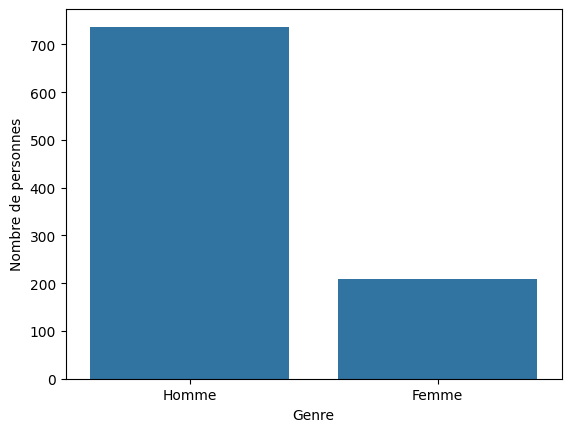

In [112]:
sns.countplot(x='label', data=Y)
plt.xlabel('Genre')
plt.xticks(ticks=[0,1], labels=['Homme', 'Femme'])
plt.ylabel('Nombre de personnes')

plt.show() 

In [113]:
Y.head()

,label
0,0
1,1
2,0
3,1
4,0


In [114]:
# Fonction pour appliquer la transformation FFT (Fast Fourier Transform)
def apply_fft(data):
    transformed_data = np.zeros_like(data, dtype=complex)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                transformed_data[i, j, k, :] = fft(data[i, j, k, :])
    return transformed_data

frequency_data = apply_fft(dataset)
print(frequency_data.shape) 


(946, 40, 7, 500)


In [115]:
# Fonction pour calculer les paramètres de Hjorth : Activité, Mobilité, et Complexité

def hjorth_parameters(data):
    """Calculate Hjorth parameters: Activity, Mobility, and Complexity."""
    first_deriv = np.diff(data)
    second_deriv = np.diff(first_deriv)
    
    activity = np.var(data)
    mobility = np.sqrt(np.var(first_deriv) / activity)
    complexity = np.sqrt(np.var(second_deriv) / np.var(first_deriv)) / mobility
    
    return activity, mobility, complexity


In [116]:
# Fonction pour calculer l'entropie spectrale

def spectral_entropy(data, sampling_rate):
    """Calculate spectral entropy."""
    power_spectrum = np.abs(np.fft.fft(data))**2
    power_spectrum = power_spectrum[:len(power_spectrum) // 2]
    ps_norm = power_spectrum / np.sum(power_spectrum)
    entropy = -np.sum(ps_norm * np.log2(ps_norm + 1e-12))
    return entropy


In [117]:
# Fonction pour extraire les caractéristiques des données
def extract_features(data, sampling_rate=250):
    features = []
    for sample in data:
        sample_features = []
        for segment in sample:
            for channel in segment:
                # Calcul des features
                hjorth_params = hjorth_parameters(channel)
                entropy = spectral_entropy(channel, sampling_rate)
                sample_features.extend(hjorth_params)
                sample_features.append(entropy)
        features.append(sample_features)
    return np.array(features)

In [118]:
features_data = extract_features(frequency_data.real)
print(features_data.shape)

C:\Users\seddi\AppData\Local\Temp\ipykernel_66720\3914894717.py:9: RuntimeWarning: invalid value encountered in scalar divide
  mobility = np.sqrt(np.var(first_deriv) / activity)
C:\Users\seddi\AppData\Local\Temp\ipykernel_66720\3914894717.py:10: RuntimeWarning: invalid value encountered in scalar divide
  complexity = np.sqrt(np.var(second_deriv) / np.var(first_deriv)) / mobility
C:\Users\seddi\AppData\Local\Temp\ipykernel_66720\4205310169.py:7: RuntimeWarning: invalid value encountered in divide
  ps_norm = power_spectrum / np.sum(power_spectrum)


(946, 1120)


In [119]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features_data, Y, test_size=0.2, random_state=42)

In [120]:
#Processing
# Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#imputation des valeurs manquantes
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)



In [121]:
#Gerer le desiquilibre des classes
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [122]:

# Reshape pour le model
X_train = X_train.reshape(X_train.shape[0], 40, 7, -1)
X_test = X_test.reshape(X_test.shape[0], 40, 7, -1)


In [123]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1182, 40, 7, 4) (190, 40, 7, 4) (1182, 1) (190, 1)


In [124]:
# Creation du modele 
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(300, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(40, 7, 4)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(100, kernel_size=(1, 1), activation='relu', padding='same'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


C:\Users\seddi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [125]:
# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Entraînement du modèle
m = model.fit(X_train, y_train, epochs=20,batch_size=32, validation_data=(X_test, y_test))#, validation_data=(X_test, y_test)



Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 227ms/step - accuracy: 0.5238 - loss: 0.6960 - val_accuracy: 0.6158 - val_loss: 1.2920
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.7733 - loss: 0.5575 - val_accuracy: 0.7316 - val_loss: 6.0051
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8587 - loss: 0.3569 - val_accuracy: 0.6263 - val_loss: 4.0285
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8945 - loss: 0.2661 - val_accuracy: 0.7632 - val_loss: 10.2144
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9103 - loss: 0.2117 - val_accuracy: 0.4737 - val_loss: 10.3738
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9111 - loss: 0.2060 - val_accuracy: 0.5368 - val_loss: 10.6406
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9533 - loss: 0.1238 - val_accuracy: 0.7000 - val_loss: 15.2180
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9561 - loss: 0.1114 - val_accuracy: 0

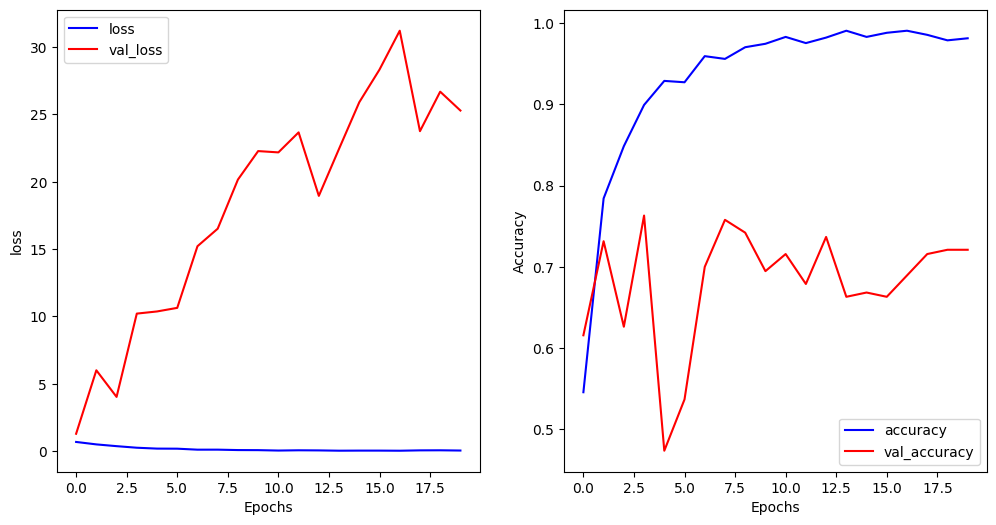

In [126]:
# Visualization of loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(m.history["loss"], color="b")
plt.plot(m.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend(labels=['loss','val_loss'])
# Visualization of accuracy
plt.subplot(1, 2, 2)
plt.plot(m.history["accuracy"], color="b")
plt.plot(m.history["val_accuracy"], color="r")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(labels=['accuracy','val_accuracy'])

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step


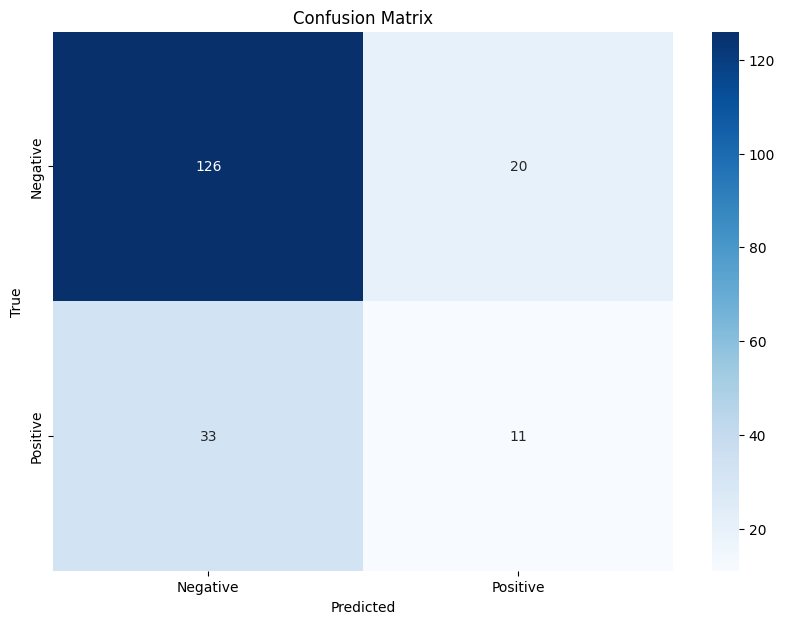

In [127]:
#Evaluation

y_pred_prob = model.predict(X_test)
# Convertir les probabilités en classes binaires
y_pred = (y_pred_prob > 0.5).astype(int)
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
# Afficher la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [128]:

# Afficher un rapport de classification
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.79      0.86      0.83       146
    Positive       0.35      0.25      0.29        44

    accuracy                           0.72       190
   macro avg       0.57      0.56      0.56       190
weighted avg       0.69      0.72      0.70       190



In [129]:
#Sauvegarde du modele
model.save('streamlit/model_cnn.h5') 

In [130]:
# charger et evaluer le model avec les données de test
dataset_test = apply_fft(dataset_test)
dataset_test = extract_features(dataset_test.real)
dataset_test = dataset_test.reshape(dataset_test.shape[0], 40, 7, -1)
dataset_test.shape




(946, 40, 7, 4)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


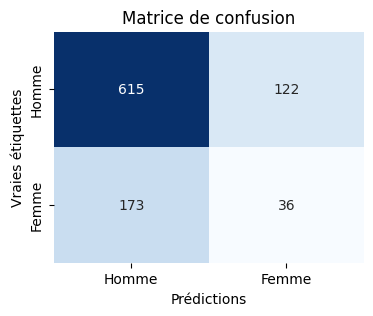

In [131]:
# Evaluation sur les données test
y_pred = model.predict(dataset_test)
y_pred
# Convertir les probabilités en classes prédites (0 ou 1)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calculer la matrice de confusion
y_test=y_set.drop('id', axis=1)
conf_matrix = confusion_matrix(y_test, y_pred_classes)
# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Homme', 'Femme'], yticklabels=['Homme', 'Femme'], cbar=False)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de confusion')
plt.show()



In [132]:
# Calculer le rappel (recall) pour la classe positive (1)
recall = recall_score(y_test, y_pred_classes)
print("Rappel (recall) :", recall)

# Calculer le score F1
f1 = f1_score(y_test, y_pred_classes)
print("Score F1 :", f1)



Rappel (recall) : 0.1722488038277512
Score F1 : 0.19618528610354224
